# Chapter 7 [RNN을 사용한 문장 생성]
---
이번 장에서는 sequence to sequence라는 새로운 구조의 신경망을 다룹니다.  
seq2seq 라고 말하며 한 시계열 데이터를 다른 시계열 데이터로 변환하는 신경망입니다.  

## 1. seq2seq

### seq2seq의 원리
---
seq2seq를 Encoder-Decoder 모델이라고도 합니다.  
이름이 말해주듯이 여기에는 2개의 모듈, Encoder와 Dcoder가 등장합니다.  
우리말을 영어로 번역하는 예를 생각해보죠.  
<img src=img/fig7-5.png width='500'>  
그림에서 보듯 Encoder와 Decoder가 시계열 데이터를 변환합니다.  
이때 Encoder가 인코딩한 정보에는 번역에 필요한 정보가 조밀하게 응축되어 있습니다.  
Decoder는 조밀하게 응축된 이 정보를 바탄으로 도착어 문장을 생성하는 것이죠.  

전체 과정을 자세히 살펴보겠습니다.  
먼저 Encoder의 처리 부분 입니다.  
<img src=img/fig7-6.png width='800'>  
Encoder가 출력하는 벡터 h는 LSTM 계층의 마지막 은닉 상태입니다.  
이 마지막 은닉 상태 h에 입력 문장(출발어)을 번역하는 데 필요한 정보가 인코딩됩니다.  
여기서 중요한 점은 LSTM의 은닉 상태h는 고정 길이 벡터라는 사실입니다.  
따라서 인코딩한다라는 것은 임의 길이의 문장을 고정 길이 벡터로 변환하는 작업이 됩니다.  
<img src=img/fig7-7.png width='500'>  
그리고 Decoder는 인코딩된 고정 길이 벡터를 입력받아 다른 문장을 생성하게 됩니다.  
<img src=img/fig7-8.png width='800'>  
<img src=img/fig7-9.png width='800'>  

### 시계열 데이터 변환용 장난감 문제
---
머신러닝을 평가하고자 만든 간단한 문제를 '장난감 문제'라고 합니다.  
우리는 시계열 반환 문제의 예로 '더하기'를 다루겠습니다.  
예를들어 "57+5"와 같은 문자열을 seq2seq에 건네면 "62"라는 정답을 내놓도록 학습시킬 겁니다.  
<img src=img/fig7-10.png width='400'>  

그런데 우리는 지금까지 word2vec이나 언어 모델 등에서 문장을 '단어' 단위로 분할해왔습니다.  
하지만 문장을 반드시 단어로 분할해야 하는 건 아니랍니다.  
이번 문제에서는 단어가 아닌 '문자' 단위로 분할하려 합니다.  
예컨대 "57+5"가 입력되면 ['5', '7', '+', '5']라는 리스트로 처리하는 걸 말합니다.

### 가변 길이 시계열 데이터
---
우리는 '덧셈'을 문자(숫자)의 리스트로써 다루기로 했습니다.  
이때 주의할 점은 덧셈 문장이나 그 답의 문자 수가 문제마다 다르다는 것입니다.  
예컨대 "57+5"는 총 4 문자이고 "628+521"은 총 7 문자입니다.  

이처럼 이번 '덧셈' 문제에서는 샘플마다 데이터의 시간 방향 크기가 다릅니다.  
따라서 미니배치 처리를 하려면 추가 작업이 필요합니다.  
가변 길이 시계열 데이터를 미니배치로 학습하기 위한 가장 단순한 방법은 **패딩**<sup>padding</sup>을 사용하는 것입니다.  
패딩이란 원래의 데이터에 의미 없는 데이터를 채워 모든 데이터의 길이를 균일하게 맞추는 기법입니다.  
<img src=img/fig7-11.png width='700'>  
이번 문제에서는 0~999 사이의 숫자 2개만 더하기로 하겠습니다.  
따라서 '+'까지 포함하면 입력의 최대 문자 수는 7이 되고, 덧셈 결과는 최대 4 문자입니다.  
결과값은 입력값과 구분하기 위해 앞에 구분자로 밑줄(_)을 붙이기로 하겠습니다.  
<img src=img/fig7-12.png width='400'>  

## 2. seq2seq 구현

### Encoder 클래스
---
Encoder 클래스는 문자열을 받아 벡터 h로 변환합니다.  
<img src=img/fig7-13.png width='300'>  
우리는 RNN을 이용해 Encoder를 구성합니다. 여기에서는 LSTM 계층을 이용해보죠.  
<img src=img/fig7-14.png width='800'>  
<img src=img/fig7-15.png width='300'>  

### Decoder 클래스
---
Decoder 클래스는 Encoder 클래스가 출력한 h를 받아 목적으로 하는 다른 문자열을 출력합니다.  
<img src=img/fig7-16.png width='500'>  
<img src=img/fig7-17.png width='800'>  
위 그림은 Decoder의 학습 시 계층 구성을 보여줍니다.  
여기에서 정답 데이터는 "_62" 입니다만, 이력 데이터를 ['_', '6', '2', ' ']로 주고, 이에 대응하는 출력은['6', '2', ' ', ' ']이 되도록 학습시킵니다.  
<img src=img/fig7-18.png width='800'>  
<img src=img/fig7-19.png width='500'>  

### seq2seq 클래스
---

In [1]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

### seq2seq 평가
---

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 4[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 6[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 6[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 7[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 8[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 9[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 10[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 10[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 11[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 12[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26

Q 77+85  
T 162 
X 156 
---
Q 975+164
T 1139
X 1160
---
Q 582+84 
T 666 
X 658 
---
Q 8+155  
T 163 
X 164 
---
Q 367+55 
T 422 
X 431 
---
Q 600+257
T 857 
X 838 
---
Q 761+292
T 1053
X 1039
---
Q 830+597
T 1427
X 1411
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 227 
---
검증 정확도 5.040%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 2[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.99
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 141 / 351 | 시간 5[s] | 손실 1.00
| 에폭 9 |  반복 161 / 351 | 시간 5[s] | 손실 0.99
| 에폭 9 |  반복 181 / 351 | 시간 6[s] | 손실 0.97
| 에폭 9 |  반복 201 / 351 | 시간 7[s] | 손실 1.01
| 에폭 9 |  반복 221 / 351 | 시간 8[s] | 손실 0.98
| 에폭 9 |  반복 241 / 351 | 시간 8[s] | 손실 0.99
| 에폭 9 |  반복 261 / 351 | 시간 9[s] | 손실 0.99
| 에폭 9 |  반복 281 / 351 | 시간 10[s] | 손실 0.97
| 에폭 9 |  반복 301 / 351 | 시간 10[s] | 손실 0.98
| 에폭 9 |  반복 321 / 351

| 에폭 16 |  반복 161 / 351 | 시간 5[s] | 손실 0.85
| 에폭 16 |  반복 181 / 351 | 시간 6[s] | 손실 0.86
| 에폭 16 |  반복 201 / 351 | 시간 7[s] | 손실 0.88
| 에폭 16 |  반복 221 / 351 | 시간 7[s] | 손실 0.89
| 에폭 16 |  반복 241 / 351 | 시간 8[s] | 손실 0.88
| 에폭 16 |  반복 261 / 351 | 시간 9[s] | 손실 0.88
| 에폭 16 |  반복 281 / 351 | 시간 9[s] | 손실 0.86
| 에폭 16 |  반복 301 / 351 | 시간 10[s] | 손실 0.84
| 에폭 16 |  반복 321 / 351 | 시간 11[s] | 손실 0.86
| 에폭 16 |  반복 341 / 351 | 시간 12[s] | 손실 0.88
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1136
---
Q 582+84 
T 666 
X 672 
---
Q 8+155  
T 163 
X 159 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 866 
---
Q 761+292
T 1053
X 1073
---
Q 830+597
T 1427
X 1424
---
Q 26+838 
T 864 
X 862 
---
Q 143+93 
T 236 
X 232 
---
검증 정확도 7.720%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.86
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.84
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.90
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.88
| 에폭 17 |  반복 81 / 351 | 시간 3[s] | 손실 0.91
| 에폭 17 |  반복 101 / 351 | 시간 3[s] | 손실 0.87
| 에폭 

검증 정확도 6.980%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.79
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.83
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.79
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.77
| 에폭 24 |  반복 81 / 351 | 시간 3[s] | 손실 0.78
| 에폭 24 |  반복 101 / 351 | 시간 3[s] | 손실 0.78
| 에폭 24 |  반복 121 / 351 | 시간 4[s] | 손실 0.78
| 에폭 24 |  반복 141 / 351 | 시간 5[s] | 손실 0.77
| 에폭 24 |  반복 161 / 351 | 시간 5[s] | 손실 0.82
| 에폭 24 |  반복 181 / 351 | 시간 6[s] | 손실 0.86
| 에폭 24 |  반복 201 / 351 | 시간 7[s] | 손실 0.81
| 에폭 24 |  반복 221 / 351 | 시간 8[s] | 손실 0.80
| 에폭 24 |  반복 241 / 351 | 시간 8[s] | 손실 0.80
| 에폭 24 |  반복 261 / 351 | 시간 9[s] | 손실 0.81
| 에폭 24 |  반복 281 / 351 | 시간 10[s] | 손실 0.80
| 에폭 24 |  반복 301 / 351 | 시간 10[s] | 손실 0.79
| 에폭 24 |  반복 321 / 351 | 시간 11[s] | 손실 0.76
| 에폭 24 |  반복 341 / 351 | 시간 12[s] | 손실 0.76
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1151
---
Q 582+84 
T 666 
X 665 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
X 427 
---
Q 600+257
T 857 
X 859 
---
Q 761+292
T 1053
X 1063
---


C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\anaconda\lib\site-packages\

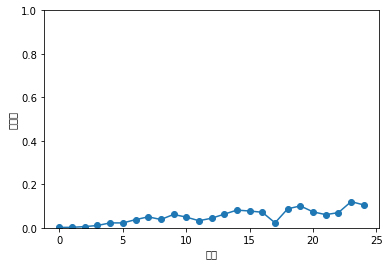

In [3]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hideen_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

## 3. seq2seq 개선

### 입력 데이터 반전(Reverse)
---
첫 번째 개선안은 아래 그림처럼 입력 데이터의 순서를 반전시키는 것입니다.  
입력 데이터 반전은 데이터 셋을 읽은 후 다음 코드를 추가해주면 됩니다.  
``` python
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
```
<img src=img/fig7-24.png width='500'>  
데이터를 반전시킨 결과 정답률이 5~60%까지 올랐습니다.  

이 데이터를 반전시키는 효과는 어떤 문제를 다루느냐에 따라 다르지만, 대부분의 경우 더 좋은 결과로 이어집니다.  

### 엿보기(Peeky)
---
<img src=img/fig7-25.png width='800'>  
입력 데이터는 Encoder계층을 지나 고정 길이 벡터 **h**로 변환됩니다.  
이때 **h** 안에는 Decoder에게 필요한 정보가 모두 담겨 있습니다. 즉, **h**가 Decoder에 있어서는 유일한 정보인 셈입니다.  
그러나 현제의 seq2seq는 위 그림과 같이 최초 시각의 LSTM 계층만이 벡터 **h**를 이용하고 있습니다.  
이 중요한 정보인 **h**를 더 활용할 수는 없을까요?  

두 번째 개산안은 중요한 정보가 담긴 Encoder의 출력 **h**를 Decoder의 다른 계층에게도 전해주는 것입니다.
<img src=img/fig7-26.png width='800'>  
기존에는 하나의 LSTM만이 소유하던 중요 정보 **h**를 여러 계층이 공유합니다. 이는 집단지성에 비유할 수 있겠습니다.  
즉, 중요한 정보를 한 사람이 독점하는 게 아니라 많은 사람과 공유한다면 더 올바른 결정을 내릴 가능서이 커질 겁니다.  

그런데 그림에서는 LSTM 계층과 Affine 계층에 입력되는 벡터가 2개씩이 되었습니다. 이는 두 벡터가 연결<sup>concatenate</sup>된 것을 의미합니다.  
그래서 두 벡터의 연결을 concat 노드를 이용해 표현하겠습니다.  
<img src=img/fig7-27.png width='600'>  

In [5]:
import sys
sys.path.append('..')
from common.time_layers import *

class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 4. 개선된 seq2seq로 학습

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 4[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 5[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 6[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 7[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 8[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 9[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 9[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 10[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 11[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 12[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 13[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 14[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1023
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1111
---
Q 2

| 에폭 8 |  반복 341 / 351 | 시간 16[s] | 손실 0.34
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 657 
---
Q 8+155  
T 163 
X 155 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1438
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 65.060%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 3[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 3[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 4[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 5[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 6[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 7[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 8[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 9[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 9[s] | 손실 0.25
| 에폭 9 |  반복 241 / 351 | 시간 10[s] | 손실 0.24
| 에폭 9 |  반복 261 / 351 | 시간 11[s] | 손실 0.24
| 에폭 9 |  반복 281 / 351 | 시간 12[s] | 손실 0.23
| 에폭 9 |  반복 301 / 

| 에폭 16 |  반복 141 / 351 | 시간 5[s] | 손실 0.04
| 에폭 16 |  반복 161 / 351 | 시간 6[s] | 손실 0.03
| 에폭 16 |  반복 181 / 351 | 시간 7[s] | 손실 0.04
| 에폭 16 |  반복 201 / 351 | 시간 8[s] | 손실 0.03
| 에폭 16 |  반복 221 / 351 | 시간 9[s] | 손실 0.03
| 에폭 16 |  반복 241 / 351 | 시간 10[s] | 손실 0.03
| 에폭 16 |  반복 261 / 351 | 시간 11[s] | 손실 0.03
| 에폭 16 |  반복 281 / 351 | 시간 11[s] | 손실 0.04
| 에폭 16 |  반복 301 / 351 | 시간 12[s] | 손실 0.03
| 에폭 16 |  반복 321 / 351 | 시간 13[s] | 손실 0.03
| 에폭 16 |  반복 341 / 351 | 시간 14[s] | 손실 0.03
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 95.820%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.04
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.03
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.03
| 에폭 17 |  반복 81 / 351 | 시간 3[s] | 손실 0.03
|

검증 정확도 98.300%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.02
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.02
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.01
| 에폭 24 |  반복 81 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 101 / 351 | 시간 4[s] | 손실 0.01
| 에폭 24 |  반복 121 / 351 | 시간 5[s] | 손실 0.01
| 에폭 24 |  반복 141 / 351 | 시간 5[s] | 손실 0.02
| 에폭 24 |  반복 161 / 351 | 시간 6[s] | 손실 0.01
| 에폭 24 |  반복 181 / 351 | 시간 7[s] | 손실 0.02
| 에폭 24 |  반복 201 / 351 | 시간 8[s] | 손실 0.02
| 에폭 24 |  반복 221 / 351 | 시간 9[s] | 손실 0.04
| 에폭 24 |  반복 241 / 351 | 시간 10[s] | 손실 0.04
| 에폭 24 |  반복 261 / 351 | 시간 10[s] | 손실 0.03
| 에폭 24 |  반복 281 / 351 | 시간 11[s] | 손실 0.03
| 에폭 24 |  반복 301 / 351 | 시간 12[s] | 손실 0.04
| 에폭 24 |  반복 321 / 351 | 시간 13[s] | 손실 0.04
| 에폭 24 |  반복 341 / 351 | 시간 13[s] | 손실 0.05
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
-

C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\anaconda\lib\site-packages\

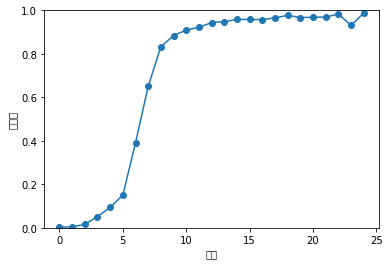

In [6]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()